In [1]:
%load_ext autoreload
%autoreload 2

from matplotlib import pyplot as plt
import utils.visualisations
import numpy as np
import torch
import torch.nn as nn
import torchvision.datasets
import torchvision.transforms as transforms

import utils.metrics
import utils.model

import models.mnist
import models.resnet
import models.resnet_dropout
from torchensemble import VotingClassifier

In [5]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device("cpu")
print('Using device:', device)
print()

# Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3, 1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3, 1), 'GB')

Using device: cuda

NVIDIA GeForce RTX 2070 SUPER
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [6]:
transforms_train = torchvision.transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
            ])

transforms_test = torchvision.transforms.Compose(
    [
        # transforms.RandomRotation(degrees=(25, 25)),
        # transforms.ColorJitter(brightness=.4, saturation=.4,hue=.4),
        transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
    ])

data_train = torchvision.datasets.CIFAR100(
    "cifar100", download=True, train=True, transform=transforms_train)
data_train, data_val = torch.utils.data.random_split(data_train, [45000, 5000])

data_loader_train = torch.utils.data.DataLoader(data_train,
                                                batch_size=64,
                                                shuffle=True,
                                                )
data_loader_val = torch.utils.data.DataLoader(data_val,
                                                batch_size=64,
                                                shuffle=False,
                                                )

data_test = torchvision.datasets.CIFAR100(
    "cifar100", download=True, train=False, transform=transforms_test)
data_loader_test = torch.utils.data.DataLoader(data_test,
                                               batch_size=64,
                                               shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


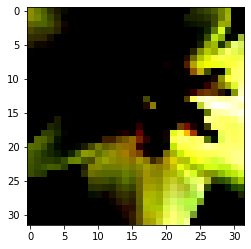

In [7]:
plt.imshow(data_test[5][0].swapaxes(0,2))

In [8]:
dataset_sizes = {"train": len(data_train), "val": len(data_val), "test": len(data_test)}
data_loaders = {"train": data_loader_train, "val": data_loader_val, "test": data_loader_test}

In [9]:
from torchensemble.utils import io
model = models.resnet.ResNet18(
    num_classes=100).to(device)
ensemble = VotingClassifier(estimator=model, n_estimators=5)
io.load(ensemble) 

In [10]:
model = torch.load("models/cifar100_resnet18_train_val_split")
model_dropout = torch.load("models/cifar100_resnet18_0.2dropout_all")
model_dropout.load_state_dict(model.state_dict())
model = model_dropout
utils.mc_dropout.set_dropout_p(model, model, .03)
model.dropout = torch.nn.Dropout(p=0)

model_dropout = torch.load("models/cifar100_resnet18_0.2dropout_all")
utils.mc_dropout.set_dropout_p(model_dropout, model_dropout, .15)
model_dropout.dropout = torch.nn.Dropout(p=0)

In [11]:
# model = models.resnet_dropout.ResNet18Dropout(num_classes=100).to(device)
# print(model)
# optimizer = torch.optim.Adam(model.parameters())
# criterion = nn.CrossEntropyLoss()
# train_progress = utils.model.train_model(
#     model, 50, optimizer, criterion, data_loaders, device)

In [12]:
from utils.temperature_scaling import ModelWithTemperature
scaled_model = ModelWithTemperature(model)
scaled_model.set_temperature(data_loader_val)

Before temperature - NLL: 0.754, ECE: 0.078
Optimal temperature: 1.739
After temperature - NLL: 0.612, ECE: 0.018


ModelWithTemperature(
  (model): ResNetDropout(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential()
        (dropout): Dropout2d(p=0.03, inplace=False)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kern

In [13]:

progress_ensemble = utils.model.run_validation(
    ensemble, data_loaders["test"], utils.metrics.Progress(), device, use_mc_dropout=False)
progress_model = utils.model.run_validation(
    model, data_loaders["test"], utils.metrics.Progress(), device, use_mc_dropout=True)
progress_model_dropout = utils.model.run_validation(
    model_dropout, data_loaders["test"], utils.metrics.Progress(), device, use_mc_dropout=True)
progress_scaled_model = utils.model.run_validation(
    scaled_model, data_loaders["test"], utils.metrics.Progress(), device, use_mc_dropout=False)

Avg. acc.: 65.84: 100%|██████████| 157/157 [00:02<00:00, 54.52it/s]


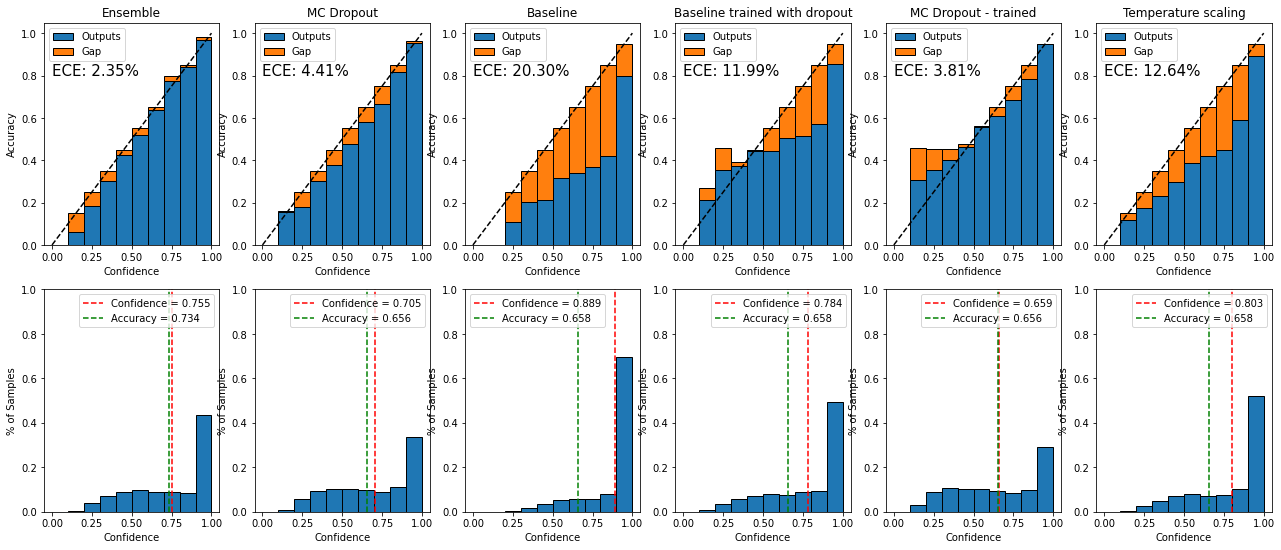

In [24]:
dropout_max_probs = progress_model.dropout_outputs.max(axis=-1)
trained_dropout_max_probs = progress_model_dropout.dropout_outputs.max(axis=-1)

ensemble_max_probs = progress_ensemble.logits.max(axis=1)
utils.visualisations.calibration_graph([
        ("Ensemble", ensemble_max_probs, np.argsort(ensemble_max_probs), progress_ensemble.predictions),
        ("MC Dropout", dropout_max_probs, np.argsort(dropout_max_probs), progress_model.dropout_predictions),
        ("Baseline", progress_model.max_probs, np.argsort(progress_model.max_probs), progress_model.predictions),
        ("Baseline trained with dropout", progress_model_dropout.max_probs, np.argsort(progress_model.max_probs), progress_model.predictions),
        ("MC Dropout - trained", trained_dropout_max_probs, np.argsort(trained_dropout_max_probs), progress_model.dropout_predictions),
        ("Temperature scaling", progress_scaled_model.max_probs, np.argsort(progress_scaled_model.max_probs), progress_scaled_model.predictions)
    ],
    progress_model.labels,
    )

In [18]:
y_true = nn.functional.one_hot(torch.tensor(progress_model.labels.astype("long")))

print("Brier score")
print("Ensemble: " + str(utils.metrics.compute_brier_score_avg(progress_ensemble.logits, y_true)))
print("MC Dropout: " + str(utils.metrics.compute_brier_score_avg(progress_model.dropout_outputs, y_true)))
print("Baseline: " + str(utils.metrics.compute_brier_score_avg(progress_model.probs, y_true)))
print("Baseline trained with dropout: " + str(utils.metrics.compute_brier_score_avg(progress_model_dropout.probs, y_true)))
print("MC Dropout - trained: " + str(utils.metrics.compute_brier_score_avg(progress_model_dropout.dropout_outputs, y_true)))
print("Temperature scaling: " + str(utils.metrics.compute_brier_score_avg(progress_scaled_model.probs, y_true)))

Brier score
Ensemble: 0.003734451324129658
MC Dropout: 0.0046716287387057
Baseline: 0.00553298274156638
Baseline trained with dropout: 0.005241850545741098
MC Dropout - trained: 0.004703617915197349
Temperature scaling: 0.004911893259544999


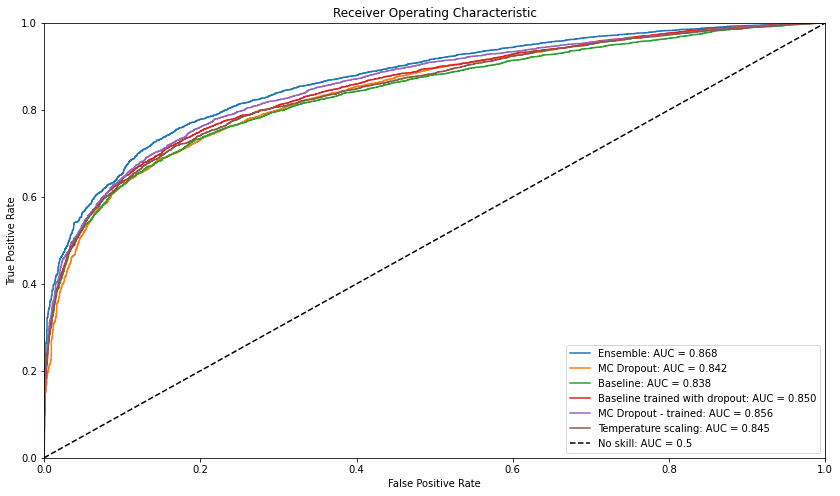

In [31]:
import sklearn.metrics

def compute_model_stats(correct, max_probs, label):
    fpr, tpr, _ = sklearn.metrics.roc_curve(correct, max_probs)
    roc_auc = sklearn.metrics.auc(fpr, tpr)

    prec, recall, _ = sklearn.metrics.precision_recall_curve(correct, max_probs)
    aupr = sklearn.metrics.auc(recall, prec)

    return {
        "fpr":fpr,
        "tpr":tpr,
        "auroc":roc_auc,
        "prec": prec,
        "recall": recall,
        "aupr": aupr,
        "label": label
    }

curves = []




correct = progress_ensemble.predictions == progress_ensemble.labels
max_probs = progress_ensemble.logits.max(axis=-1)
curves.append(compute_model_stats(correct, max_probs, "Ensemble"))

correct = progress_model.dropout_predictions == progress_model.labels
max_probs = progress_model.dropout_outputs.max(axis=-1)
curves.append(compute_model_stats(correct, max_probs, "MC Dropout"))

correct = progress_model.predictions == progress_model.labels
max_probs = progress_model.max_probs
curves.append(compute_model_stats(correct, max_probs, "Baseline"))

correct = progress_model_dropout.predictions == progress_model.labels
max_probs = progress_model_dropout.max_probs
curves.append(compute_model_stats(correct, max_probs, "Baseline trained with dropout"))

correct = progress_model_dropout.dropout_predictions == progress_model.labels
max_probs = progress_model_dropout.dropout_outputs.max(axis=-1)
curves.append(compute_model_stats(correct, max_probs, "MC Dropout - trained"))

correct = progress_scaled_model.predictions == progress_scaled_model.labels
max_probs = progress_scaled_model.max_probs
curves.append(compute_model_stats(correct, max_probs, "Temperature scaling"))



plt.figure(figsize=(14,8))
plt.title('Receiver Operating Characteristic')
for curve in curves:
    plt.plot(curve["fpr"], curve["tpr"], label = f"{curve['label']}: AUC = {curve['auroc']:.3f}" )
plt.plot([0, 1], [0, 1],'k--', label=f"No skill: AUC = 0.5")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend()

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

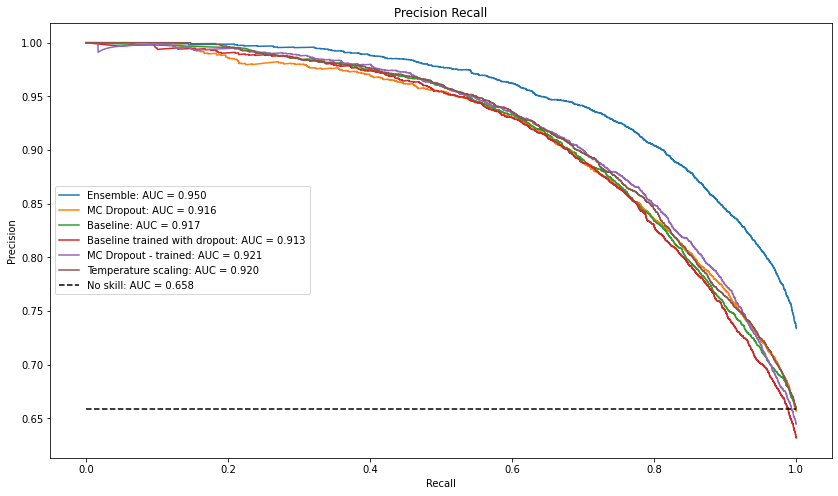

In [32]:
no_skill = correct.sum() / len(correct)
plt.figure(figsize=(14,8))
plt.title('Precision Recall')
for curve in curves:
    plt.plot(curve["recall"], curve["prec"], label=f"{curve['label']}: AUC = {curve['aupr']:.3f}")
# axis labels
plt.plot([0, 1], [no_skill, no_skill], color="k", linestyle='--', label=f'No skill: AUC = {no_skill:.3f}')

plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

In [3]:
class model_metrics:
    def __init__(self) -> None:
        self.acc = []
        self.ece = []
        self.brier = []
        self.auroc = []
        self.aupr = []
        self.strengths = []

    def __str__(self) -> str:
        return str(vars(self))

In [23]:
curves = {
    "ensemble": model_metrics(),
    "mcd": model_metrics(),
    "baseline": model_metrics(),
    "baseline_dropout": model_metrics(),
    "mcd_trained":model_metrics(),
    "temp_scaling":model_metrics()
}


def update_model_metrics(progress, probs, max_probs, predictions, labels, bins, m:model_metrics, strength):
    accs, errors, counts = utils.metrics.compute_calibration_metrics(predictions, labels, max_probs, np.argsort(max_probs), bins)
    ece = np.average(errors, weights=counts) * 100
    mean_acc = np.average(accs, weights=counts)

    y_true = nn.functional.one_hot(torch.tensor(labels.astype("long")))
    brier = utils.metrics.compute_brier_score_avg(progress.logits, y_true)

    correct = predictions == labels
    curve =  compute_model_stats(correct, max_probs, "dasd")
    m.acc.append(mean_acc)
    m.ece.append(ece)
    m.brier.append(brier)
    m.auroc.append(curve["auroc"])
    m.aupr.append(curve["aupr"])
    m.strengths.append(strength)



for s in range(0, 60, 5):
    transforms_test = torchvision.transforms.Compose(
        [
            transforms.RandomRotation(degrees=(s,s)),
            # transforms.ColorJitter(brightness=.4, saturation=.4,hue=.4),
            transforms.ToTensor(),
            transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
        ])

    data_test = torchvision.datasets.CIFAR100(
        "cifar100", download=True, train=False, transform=transforms_test)
    data_loader_test = torch.utils.data.DataLoader(data_test,
                                                batch_size=64,
                                                shuffle=False)
    

    print(f"Strength: {s}")
    progress_ensemble = utils.model.run_validation(
        ensemble, data_loader_test, utils.metrics.Progress(), device, use_mc_dropout=False)
    progress_model = utils.model.run_validation(
        model, data_loader_test, utils.metrics.Progress(), device, use_mc_dropout=True)
    progress_model_dropout = utils.model.run_validation(
        model_dropout, data_loader_test, utils.metrics.Progress(), device, use_mc_dropout=True)
    progress_scaled_model = utils.model.run_validation(
        scaled_model, data_loader_test, utils.metrics.Progress(), device, use_mc_dropout=False)


    # dropout_max_probs = progress_model.dropout_outputs.max(axis=-1)
    # trained_dropout_max_probs = progress_model_dropout.dropout_outputs.max(axis=-1)

    bins = np.linspace(0.05, 0.95, num=10)
    labels = progress_model.labels


    max_probs = progress_ensemble.logits.max(axis=1)
    update_model_metrics(progress_ensemble, progress_ensemble.logits, max_probs, progress_ensemble.predictions, labels, bins, curves["ensemble"], s)

    max_probs = progress_model.dropout_outputs.max(axis=-1)
    update_model_metrics(progress_model, progress_model.dropout_outputs, max_probs, progress_model.dropout_predictions, labels, bins, curves["mcd"], s)
    
    max_probs = progress_model.max_probs
    update_model_metrics(progress_model, progress_model.probs, max_probs, progress_model.predictions, labels, bins, curves["baseline"], s)

    max_probs = progress_model_dropout.max_probs
    update_model_metrics(progress_model_dropout, progress_model_dropout.probs, max_probs, progress_model_dropout.predictions, labels, bins, curves["baseline_dropout"], s)

    max_probs = progress_model_dropout.dropout_outputs.max(axis=-1)
    update_model_metrics(progress_model_dropout, progress_model_dropout.dropout_outputs, max_probs, progress_model_dropout.dropout_predictions, labels, bins, curves["mcd_trained"], s)

    max_probs = progress_scaled_model.max_probs
    update_model_metrics(progress_scaled_model, progress_scaled_model.probs, max_probs, progress_scaled_model.predictions, labels, bins, curves["temp_scaling"], s)
    


Files already downloaded and verified
Strength: 0


NameError: name 'ensemble' is not defined

In [51]:
print(curves["baseline"], curves["ensemble"])

{'acc': [0.6583, 0.6262, 0.5523, 0.4385, 0.33440000000000003, 0.2585, 0.2184, 0.1886, 0.1616, 0.1186, 0.1383, 0.1494], 'ece': [20.302999999999997, 22.11, 27.5555, 35.037, 42.70949999999999, 49.2945, 53.1945, 56.858999999999995, 60.62299999999999, 67.2755, 62.625, 59.5785], 'brier': [450.44602769790265, 397.83351308901126, 359.74522500247014, 313.2188441712957, 300.3819031131739, 305.6406043127947, 304.2162793223776, 337.3727328726556, 361.7708224016, 404.33952883903606, 366.7534898887812, 333.19058161783295], 'auroc': [0.8377574769649508, 0.8237479262294183, 0.8140365642958107, 0.7746010469816275, 0.7543434363305823, 0.7208336648359029, 0.7130301467022265, 0.703506775532438, 0.6621530697320686, 0.6109597887922441, 0.654942293609691, 0.6771110226626389], 'aupr': [0.91691417230149, 0.8979769873083601, 0.8598514713081267, 0.7655245004646876, 0.6634547394814236, 0.54988739974502, 0.48022594625831794, 0.41147199765643927, 0.30081308920582384, 0.1943038107430538, 0.2706086193618435, 0.334354

In [54]:
import pickle
with open( "shifting_cifar100.pickle", "wb") as f:
    pickle.dump(curves,f)

In [4]:
import pickle
with open( "shifting_cifar100.pickle", "rb") as f:
    curves = pickle.load(f)

In [5]:
curves

{'ensemble': <__main__.model_metrics at 0x7fc4d74d4af0>,
 'mcd': <__main__.model_metrics at 0x7fc3f4601c70>,
 'baseline': <__main__.model_metrics at 0x7fc3f3b6e4f0>,
 'baseline_dropout': <__main__.model_metrics at 0x7fc3f3b6ee20>,
 'mcd_trained': <__main__.model_metrics at 0x7fc3f3b70790>,
 'temp_scaling': <__main__.model_metrics at 0x7fc3f3b76100>}

In [11]:
curves["baseline"].acc, curves["mcd"].acc

([0.6583,
  0.6262,
  0.5523,
  0.4385,
  0.33440000000000003,
  0.2585,
  0.2184,
  0.1886,
  0.1616,
  0.1186,
  0.1383,
  0.1494],
 [0.6584,
  0.6263,
  0.5523,
  0.4387,
  0.3345,
  0.2585,
  0.2186,
  0.1886,
  0.1616,
  0.1186,
  0.1383,
  0.1494])

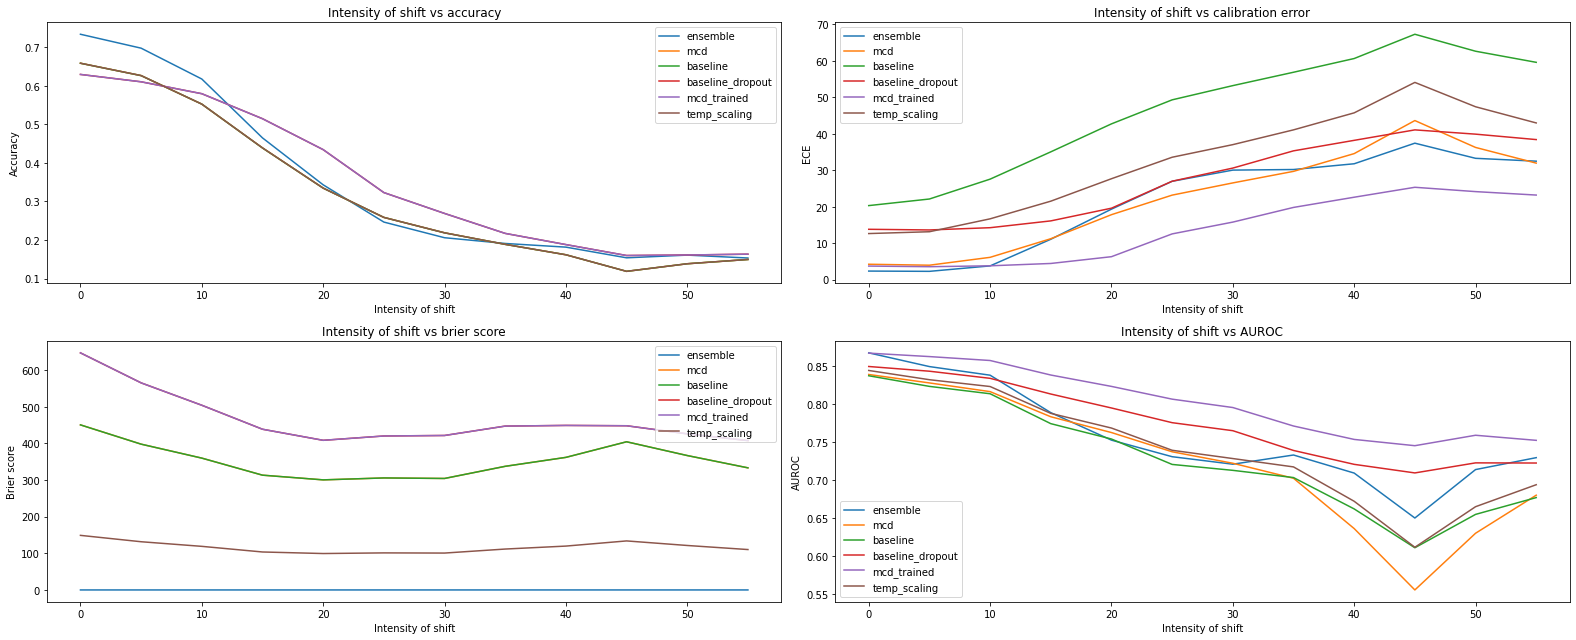

In [22]:
fig, axs = plt.subplots(2, 2, figsize=(22, 9))
for name, m in curves.items():
    ax = axs[0][0]
    ax.plot(m.strengths, m.acc, label=name)
    ax.legend()
    ax.set_title("Intensity of shift vs accuracy")
    ax.set_xlabel("Intensity of shift")
    ax.set_ylabel("Accuracy")

    ax = axs[1][0]
    ax.plot(m.strengths, m.brier, label=name)
    ax.legend()
    ax.set_title("Intensity of shift vs brier score")
    ax.set_xlabel("Intensity of shift")
    ax.set_ylabel("Brier score")

    ax = axs[0][1]
    ax.plot(m.strengths, m.ece, label=name)
    ax.legend()
    ax.set_title("Intensity of shift vs calibration error")
    ax.set_xlabel("Intensity of shift")
    ax.set_ylabel("ECE")

    ax = axs[1][1]
    ax.plot(m.strengths, m.auroc, label=name)
    ax.legend()
    ax.set_title("Intensity of shift vs AUROC")
    ax.set_xlabel("Intensity of shift")
    ax.set_ylabel("AUROC")
fig.tight_layout()